In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import json
import datetime
import math
from IPython.display import clear_output

pd.set_option('display.max_rows', 500)

In [2]:
gdf_counts = pd.read_csv("outputs/gdf_counts.csv")
gdf_counts.describe()

,gid,arr_count,dep_count,arr_avg,dep_avg
count,24.000000,24.000000,24.000000,24.000000,24.000000
mean,11.500000,442.333333,442.333333,1.215201,1.215201
std,7.071068,590.903337,552.235746,1.623361,1.517131
min,0.000000,1.000000,8.000000,0.002747,0.021978
25%,5.750000,24.000000,75.250000,0.065934,0.206731
50%,11.500000,259.500000,245.500000,0.712912,0.674451
75%,17.250000,470.000000,529.000000,1.291209,1.453297
max,23.000000,2140.000000,2173.000000,5.879121,5.969780


## Poisson distribution

Probability Mass Function:

$f(k; \lambda) = \Pr(X=k) = \frac{\lambda^k e^{-\lambda}}{k!} $

In [3]:
def poisson(k, lamb):
    return ((lamb**k)*math.exp(-lamb))/math.factorial(k)

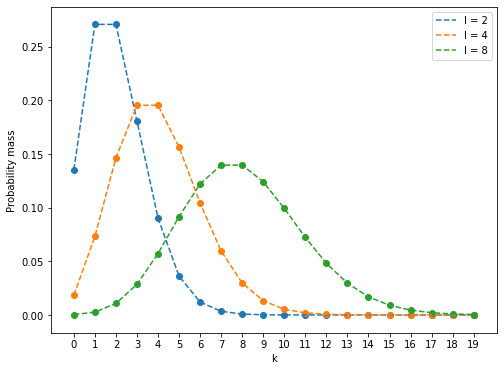

In [4]:
fig1 = plt.figure(figsize = (8,6))
ax1 = fig1.add_subplot(1,1,1)
x = np.arange(0,20,1)
lambs = [2, 4, 8]
ys = []

for lamb in lambs:
    y = [poisson(i, lamb) for i in x]
    ax1.plot(x,y, label=f"l = {lamb}", ls = '--')
    ax1.scatter(x,y)

ax1.set_xlabel("k")
ax1.set_ylabel("Probability mass")
ax1.set_xticks(x)
ax1.legend()


## Data for simulator

Text(0.5, 0, 'PMF')

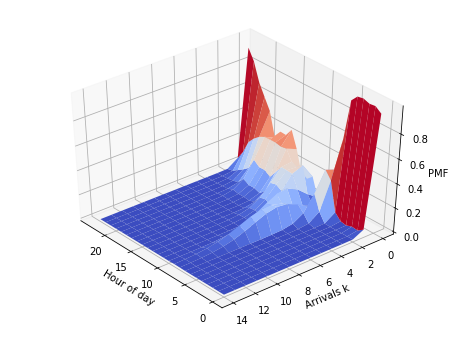

In [107]:
#from mpl_toolkits.mplot3d import Axes3D  
from mpl_toolkits import mplot3d
x = gdf_counts["arr_avg"].to_numpy()
t = np.arange(0,24,1)
y = np.arange(0,15,1)

Z = np.zeros((len(x), len(y)))
#Z = np.meshgrid(x,y)
#print(x, x.shape)
#print(y, y.shape)
#print(Z) #, Z.shape)

for i, xval in enumerate(x):
    for j, yval in enumerate(y):
        Z[i][j] = poisson(yval,xval)

fig1 = plt.figure(figsize=(8,6))

ax1 = fig1.add_subplot(1,1,1, projection='3d')
ax1.view_init(40, 140)
ax1.dist = 11
surf = ax1.plot_surface(np.asmatrix(t).T, np.asmatrix(y), np.asmatrix(Z), cmap = 'coolwarm')
ax1.set_xlabel("Hour of day")
ax1.set_ylabel("Arrivals k")
ax1.set_zlabel("PMF")

## Simple simulator

In [191]:
# Parameters
max_cars = 50
min_cars = 0



In [211]:
rng = np.random.default_rng(135)
sessions = 0

upper_saturation = 0
lower_saturation = 0

sessions_l = []
upper_saturation_l = []
lower_saturation_l = []
time_l = []

paint = False

for t in range(24*7*2):
    hour = t % 24
    arr_r = gdf_counts[gdf_counts["gid"] == hour]["arr_avg"].iloc[0]
    dep_r = gdf_counts[gdf_counts["gid"] == hour]["dep_avg"].iloc[0]
    
    arr_n = rng.poisson(arr_r)
    dep_n = rng.poisson(dep_r)
    
    sessions_temp = sessions
    sessions = max(min_cars, min(max_cars, sessions + arr_n - dep_n))
    upper_saturations = sessions_temp + arr_n - dep_n - sessions
    
    if paint:
        for j, session in enumerate(range(sessions)):
            print('* ', end='') 
        print("")
        print(f"time {t}, \tsessions: {sessions}")
        time.sleep(200/1000)
        clear_output(wait=True)
            
            
    
    #Data logging
    sessions_l.append(sessions)
    upper_saturation_l.append(upper_saturations)
    
    time_l.append(t)

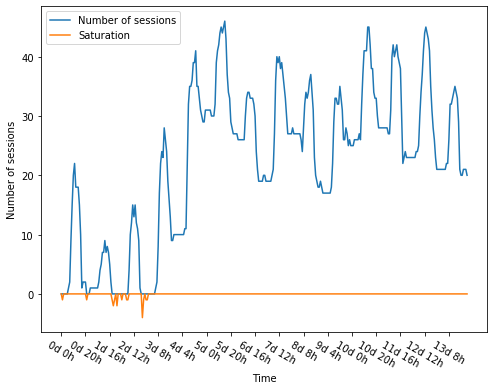

In [212]:
fig1 = plt.figure(figsize=(8,6))
ax1 = fig1.add_subplot(1,1,1)
ax1.plot(time_l, sessions_l, label = 'Number of sessions')
ax1.plot(time_l, upper_saturation_l, label='Saturation')

ax1.legend()
ax1.set_xlabel("Time")
ax1.set_ylabel("Number of sessions")
xticks = np.arange(0, max(time_l), 20)
ax1.set_xticks(xticks)
xticklabels = [f"{tick // 24}d {tick%24}h" for tick in xticks ]
ax1.set_xticklabels(xticklabels, rotation= -30);
